In [8]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
import numpy as np
from PIL import Image
import os
import json
import matplotlib.pyplot as plt
import sklearn
import cv2
import time
from ultralytics import YOLO

In [3]:
def extract_bottle(image, model, confidence_threshold=0.5, nms_threshold=0.4):
    """
    Detects a bottle in an image using a YOLO model, crops it, and returns the cropped bottle image.

    Args:
        image_path: Input image.
        model (cv2.dnn.Net): Preloaded YOLO model.
        confidence_threshold (float): Confidence threshold for YOLO detections.
        nms_threshold (float): Non-maximum suppression threshold to filter overlapping boxes.

    Returns:
        np.ndarray: Cropped image containing the detected bottle, or None if no bottle is found.
    """
    height, width = image.shape[:2]

    # YOLO input dimensions (YOLOv3/v4 typically uses 416x416 or 640x640)
    input_size = 416
    blob = cv2.dnn.blobFromImage(image, 1, (input_size, input_size), swapRB=True, crop=False)

    # Set the blob as input to the model
    model.setInput(blob)

    # Run the YOLO model
    layer_names = model.getUnconnectedOutLayersNames()
    detections = model.forward(layer_names)

    # Extract bounding boxes, confidences, and class IDs
    boxes = []
    confidences = []
    class_ids = []

    for detection in detections:
        for obj in detection:
            scores = obj[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            if confidence > confidence_threshold:
                # Scale bounding box back to the original image size
                center_x = int(obj[0])# * width)
                center_y = int(obj[1])# * height)
                box_width = int(obj[2])# * width)
                box_height = int(obj[3])# * height)

                x = int(center_x - box_width / 2)
                y = int(center_y - box_height / 2)

                boxes.append([x, y, box_width, box_height])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    # Apply non-maximum suppression to filter overlapping boxes
    indices = cv2.dnn.NMSBoxes(boxes, confidences, confidence_threshold, nms_threshold)

    for (x, y, w, h) in boxes:
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.imshow("Detections", image)
        cv2.waitKey(0)
    
    if len(indices) > 0:
        # Assume the first detected object is the bottle
        idx = indices[0][0] if isinstance(indices[0], list) else indices[0]
        x, y, w, h = boxes[idx]
        print(boxes[idx])

        # Crop the detected bottle from the image
        x = max(0, x)
        y = max(0, y)

        cropped_bottle = image[y:y+h, x:x+w]
        print(cropped_bottle)

        return cropped_bottle

    return None

In [3]:
from ultralytics import YOLO
import cv2
import numpy as np

def extract_bottle_ultralytics(image, model, confidence_threshold=0.5):
    """
    Detects a bottle in an image using an Ultralytics YOLO model, paints bounding boxes, 
    and optionally returns the cropped bottle image.

    Args:
        image (np.ndarray): Input image.
        model (YOLO): Preloaded Ultralytics YOLO model.
        confidence_threshold (float): Confidence threshold for YOLO detections.

    Returns:
        np.ndarray: Image with bounding boxes drawn, or None if no bottle is found.
    """
    # Run YOLO inference
    results = model.predict(source=image, conf=confidence_threshold, verbose=False)

    # Extract detection results
    detections = results[0].boxes.data.cpu().numpy()  # Bounding boxes, confidences, and class IDs
    height, width = image.shape[:2]

    # Check if any detections exist
    if len(detections) == 0:
        print("No bottles detected.")
        return None

    for detection in detections:
        # Extract bounding box and confidence
        x_min, y_min, x_max, y_max, confidence, class_id = detection

        # Only process detections with sufficient confidence
        if confidence >= confidence_threshold:
            # Draw bounding box
            cv2.rectangle(
                image,
                (int(x_min), int(y_min)),
                (int(x_max), int(y_max)),
                (0, 255, 0), 2
            )

            # Add label with confidence score
            label = f"Class {int(class_id)}, Conf: {confidence:.2f}"
            cv2.putText(
                image,
                label,
                (int(x_min), int(y_min) - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5, (0, 255, 0), 2
            )

    # Display the image with bounding boxes
    cv2.imshow("Detections", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return image

2024-12-09 08:09:15.291 python[11190:411452] +[IMKClient subclass]: chose IMKClient_Modern
2024-12-09 08:09:15.291 python[11190:411452] +[IMKInputSession subclass]: chose IMKInputSession_Modern


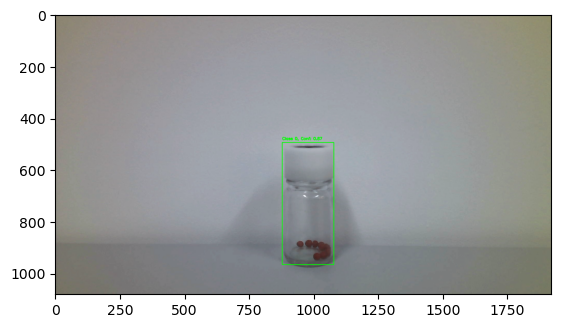

In [9]:
# Load the YOLOv8 model (pre-trained on COCO dataset or custom weights)
model = YOLO("/Users/finnferchau/dev/EH_Bottle_Dataset/models/yolo.pt")  # Replace with your custom model path if necessary

# Load an image
image = cv2.imread("/Users/finnferchau/dev/EH_Bottle_Dataset/images/img_20241125_082521.jpg")

# Detect bottles
processed_image = extract_bottle_ultralytics(image, model, confidence_threshold=0.01)

# Save or display the processed image
if processed_image is not None:
    plt.imshow(processed_image)
    plt.show()

In [ ]:
# Load YOLO model
model = cv2.dnn.readNetFromDarknet('yolov4.cfg', 'yolov4.weights')


# Set backend and target (if using GPU acceleration)
model.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
model.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

image = np.array(images[0])  # Convert to NumPy array (if it's a PIL Image)
image = (image * 255).astype(np.uint8)  # Convert from float [0,1] to uint8 [0,255] if normalized

# Extract the bottle
cropped_bottle = extract_bottle(image , model, confidence_threshold=0.1)

if cropped_bottle is not None and cropped_bottle.size > 0:
    cv2.imshow("Cropped Bottle", cropped_bottle)
    cv2.imwrite("cropped_bottle.jpg", cropped_bottle)
    cv2.waitKey(0)
else:
    print("No valid cropped image to display.")

---


In [11]:
def extract_and_resize_bottle(image_dir_path, model_path, save_folder, confidence_threshold=0.5, target_size=224):
    """
    Detects a bottle in an image using a YOLO model (.pt format), crops it
    into a centered 224x224 square (ensuring the entire bottle is visible), 
    and saves it to a specified folder.

    Args:
        image_dir_path (str): Path to the input images.
        model_path (str): Path to the YOLO .pt model.
        save_folder (str): Path to the folder where cropped images will be saved.
        confidence_threshold (float): Confidence threshold for YOLO detections.
        target_size (int): Target size for the square image (default: 224x224).

    Returns:
        None
    """
    # Load YOLO model
    model = YOLO(model_path)

    # Ensure the save folder exists
    os.makedirs(save_folder, exist_ok=True)

    # Iterate through all image files
    for file_name in os.listdir(image_dir_path):
        image_path = os.path.join(image_dir_path, file_name)

        if file_name.endswith((".jpg", ".png")):
            # Load image
            image = cv2.imread(image_path)
            if image is None:
                print(f"Could not read {image_path}. Skipping.")
                continue

            # Perform inference
            results = model.predict(source=image, conf=confidence_threshold, verbose=False)
            detections = results[0]

            if detections.boxes is None or len(detections.boxes) == 0:
                print(f"No bottles detected in {image_path}.")
                continue

            # Get bounding box of the first detected object
            box = detections.boxes[0].xyxy[0].cpu().numpy()  # [x_min, y_min, x_max, y_max]
            x_min, y_min, x_max, y_max = map(int, box)

            # Calculate width and height of the bounding box
            box_width = x_max - x_min
            box_height = y_max - y_min

            # Calculate the center of the bounding box
            center_x = x_min + box_width // 2
            center_y = y_min + box_height // 2

            # Calculate the side length of the square crop
            crop_size = max(box_width, box_height, target_size)

            # Determine the square crop boundaries
            crop_x_min = max(0, center_x - crop_size // 2)
            crop_y_min = max(0, center_y - crop_size // 2)
            crop_x_max = crop_x_min + crop_size
            crop_y_max = crop_y_min + crop_size

            # Adjust crop to ensure it fits within the image boundaries
            if crop_x_max > image.shape[1]:
                crop_x_min -= (crop_x_max - image.shape[1])
                crop_x_max = image.shape[1]
            if crop_y_max > image.shape[0]:
                crop_y_min -= (crop_y_max - image.shape[0])
                crop_y_max = image.shape[0]

            # Ensure the adjustments keep the crop within valid bounds
            crop_x_min = max(0, crop_x_min)
            crop_y_min = max(0, crop_y_min)

            # Perform cropping
            cropped_bottle = image[crop_y_min:crop_y_max, crop_x_min:crop_x_max]

            # Resize the cropped image to the target size (224x224)
            resized_bottle = cv2.resize(cropped_bottle, (target_size, target_size), interpolation=cv2.INTER_AREA)

            # Save the resized image
            save_path = os.path.join(save_folder, file_name)
            cv2.imwrite(save_path, resized_bottle)
            print(f"Processed and saved: {save_path}")

# Example usage
image_dir_path = "/Users/finnferchau/dev/EH_Bottle_Dataset/finetune_dataset/images"
model_path = "/Users/finnferchau/dev/EH_Bottle_Dataset/models/yolo.pt"
save_folder = "/Users/finnferchau/dev/EH_Bottle_Dataset/finetune_dataset_cropped"

extract_and_resize_bottle(image_dir_path, model_path, save_folder)

Processed and saved: /Users/finnferchau/dev/EH_Bottle_Dataset/finetune_dataset_cropped/img_1733749720917690000.jpg
Processed and saved: /Users/finnferchau/dev/EH_Bottle_Dataset/finetune_dataset_cropped/img_1733749776828315000.jpg
Processed and saved: /Users/finnferchau/dev/EH_Bottle_Dataset/finetune_dataset_cropped/img_1733749705090419000.jpg
Processed and saved: /Users/finnferchau/dev/EH_Bottle_Dataset/finetune_dataset_cropped/img_1733749785393620000.jpg
Processed and saved: /Users/finnferchau/dev/EH_Bottle_Dataset/finetune_dataset_cropped/img_1733749758184595000.jpg
Processed and saved: /Users/finnferchau/dev/EH_Bottle_Dataset/finetune_dataset_cropped/img_1733749752830753000.jpg
Processed and saved: /Users/finnferchau/dev/EH_Bottle_Dataset/finetune_dataset_cropped/img_1733749728405106000.jpg
Processed and saved: /Users/finnferchau/dev/EH_Bottle_Dataset/finetune_dataset_cropped/img_1733749796497544000.jpg
Processed and saved: /Users/finnferchau/dev/EH_Bottle_Dataset/finetune_dataset_c

In [12]:
def extract_bottle_bottom(image_dir_path, model_path, save_folder, confidence_threshold=0.5, target_size=224, crop_ratio=0.6):
    """
    Detects a bottle in an image using a YOLO model, crops the bottom portion of the bottle 
    (where the pellets lay), and saves it to a specified folder.

    Args:
        image_dir_path (str): Path to the input images.
        model_path (str): Path to the YOLO .pt model.
        save_folder (str): Path to the folder where cropped images will be saved.
        confidence_threshold (float): Confidence threshold for YOLO detections.
        target_size (int): Target size for the cropped image (default: 224x224).
        crop_ratio (float): Proportion of the bounding box height to crop from the bottom.

    Returns:
        None
    """
    # Load YOLO model
    model = YOLO(model_path)

    # Ensure the save folder exists
    os.makedirs(save_folder, exist_ok=True)

    # Iterate through all image files
    for file_name in os.listdir(image_dir_path):
        image_path = os.path.join(image_dir_path, file_name)

        if file_name.endswith((".jpg", ".png")):
            # Load image
            image = cv2.imread(image_path)
            if image is None:
                print(f"Could not read {image_path}. Skipping.")
                continue

            # Perform inference
            results = model.predict(source=image, conf=confidence_threshold, verbose=False)
            detections = results[0]

            # Skip if no detections are found
            if detections.boxes is None or len(detections.boxes) == 0:
                print(f"No bottles detected in {image_path}.")
                continue

            # Get bounding box of the first detected object
            box = detections.boxes[0].xyxy[0].cpu().numpy()  # [x_min, y_min, x_max, y_max]
            x_min, y_min, x_max, y_max = map(int, box)

            # Calculate the bottom portion
            bottle_height = y_max - y_min
            bottom_y_min = y_max - int(bottle_height * crop_ratio)

            # Ensure the crop is within the image bounds
            bottom_y_min = max(0, bottom_y_min)

            # Crop the bottom portion
            cropped_bottom = image[bottom_y_min:y_max, x_min:x_max]

            # Resize to the target size
            resized_cropped_bottom = cv2.resize(cropped_bottom, (target_size, target_size), interpolation=cv2.INTER_AREA)

            # Save the cropped image
            save_path = os.path.join(save_folder, file_name)
            cv2.imwrite(save_path, resized_cropped_bottom)
            print(f"Processed and saved: {save_path}")

image_dir_path = "/Users/finnferchau/dev/EH_Bottle_Dataset/images"  # Path to your images
model_path = "/Users/finnferchau/dev/EH_Bottle_Dataset/models/yolo.pt"   # Path to your YOLO model
save_folder = "/Users/finnferchau/dev/EH_Bottle_Dataset/new_cropped_bottoms"  # Folder to save cropped images

# Run the function
extract_bottle_bottom(image_dir_path, model_path, save_folder, crop_ratio=0.5)

Processed and saved: /Users/finnferchau/dev/EH_Bottle_Dataset/cropped_bottoms/img_20241125_103815.jpg
Processed and saved: /Users/finnferchau/dev/EH_Bottle_Dataset/cropped_bottoms/img_20241125_103801.jpg
Processed and saved: /Users/finnferchau/dev/EH_Bottle_Dataset/cropped_bottoms/img_20241125_131643.jpg
Processed and saved: /Users/finnferchau/dev/EH_Bottle_Dataset/cropped_bottoms/img_20241125_123521.jpg
Processed and saved: /Users/finnferchau/dev/EH_Bottle_Dataset/cropped_bottoms/img_20241125_125150.jpg
Processed and saved: /Users/finnferchau/dev/EH_Bottle_Dataset/cropped_bottoms/img_20241125_125622.jpg
Processed and saved: /Users/finnferchau/dev/EH_Bottle_Dataset/cropped_bottoms/img_20241125_104834.jpg
Processed and saved: /Users/finnferchau/dev/EH_Bottle_Dataset/cropped_bottoms/img_20241125_104607.jpg
Processed and saved: /Users/finnferchau/dev/EH_Bottle_Dataset/cropped_bottoms/img_20241125_101019.jpg
Processed and saved: /Users/finnferchau/dev/EH_Bottle_Dataset/cropped_bottoms/img_

In [7]:
import time
time.time_ns()

1733734440870073000